### Import and Read Dataset

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pyitlib import discrete_random_variable as drv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import Counter

In [2]:
df = pd.read_csv('../Data/insurance_data.csv', sep = ';')

In [3]:
df.head(5)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,"19,4","1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,"19,55","265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,"100,3","3541,4",Y


### Create Target for Prediction

Assuming that the insurance company wants to identify customers who are likely to not renew in order to follow up with them to target and retain them, the positive class in this binary classification problem is the insurees who did not renew (referred to as No-Renew in all notebooks) while the negative class is the insurees who did renew (referred to as Renew in all notebooks).

In [4]:
df['target'] = df['renewal'].map({'N': 1, 'Y': 0})
df.drop(columns=['insuree#', 'renewal'], inplace=True)

### Check distribution of target 

Target is binary, where 1 indicates insuree did not renew at next premium cycle while 0 indicates insuree renewed.

In [5]:
df.target.value_counts(normalize=True)

0    0.731455
1    0.268545
Name: target, dtype: float64

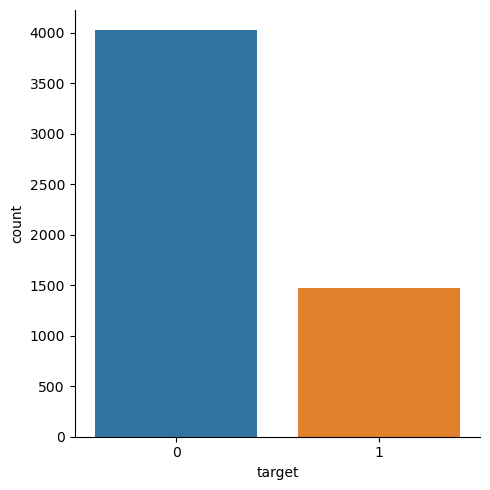

In [6]:
sns.catplot(x = "target" , kind = 'count', data = df)

### Check Missing Values
Missing values do not form an extremely large proportion of the dataset. Imputation using KNN will be tried in model.ipynb.

In [7]:
df.isna().sum() / len(df)

gender                      0.020545
is45OrOlder                 0.017455
isMarried                   0.000000
hasKids                     0.000000
insuredMonths               0.000000
termLifeInsurance           0.000000
multipleTermLifePolicies    0.000000
healthInsurance             0.000000
healthRiders                0.360364
premiumFrequency            0.020727
eStatements                 0.000000
monthlyPremium              0.000000
totalPremium                0.000000
target                      0.000000
dtype: float64

### Check Data Types

In [8]:
df.dtypes

gender                       object
is45OrOlder                 float64
isMarried                    object
hasKids                      object
insuredMonths                 int64
termLifeInsurance            object
multipleTermLifePolicies     object
healthInsurance              object
healthRiders                 object
premiumFrequency            float64
eStatements                  object
monthlyPremium               object
totalPremium                 object
target                        int64
dtype: object

Convert data type of is45OrOlder into string as it is a categorical variable to prevent misleading visualisations when investigating numerical variables. 

In [9]:
df['is45OrOlder'] = df['is45OrOlder'].astype(str)

### Investigate Numerical Columns

#### Clean monthlyPremium and totalPremium 

Clean strings into float values

In [10]:
df['monthlyPremium'] = df['monthlyPremium'].str.replace(',', '.').astype(float)
df['totalPremium'] = df['totalPremium'].str.replace(',', '.').str.strip().apply(lambda x: float(x) if len(x) != 0 else np.nan)

#### Pearson Correlation Heatmap

To investigate correlation between features, I plot a heatmap of the pairwise Pearson correlation coefficient values.

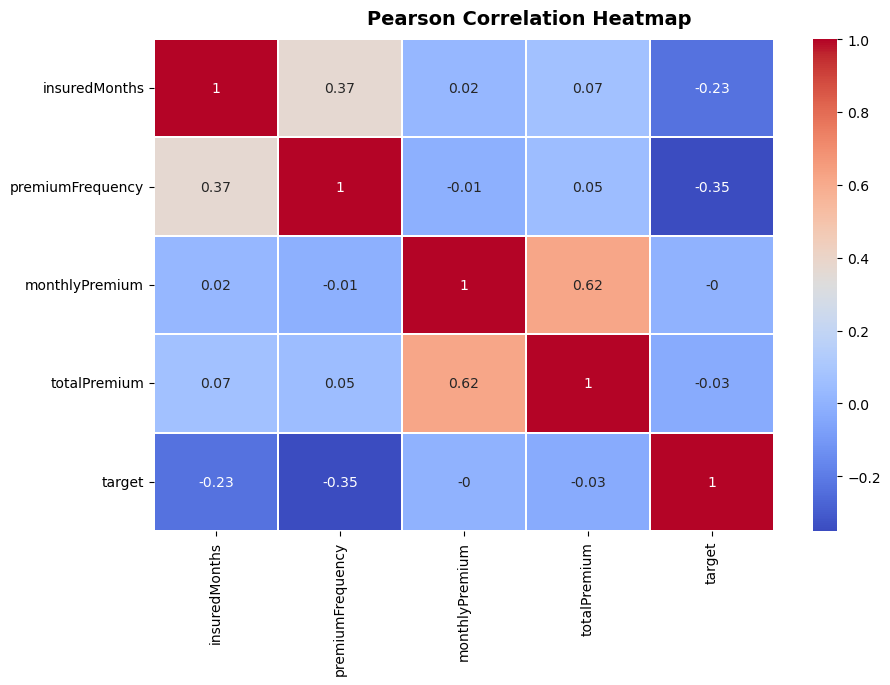

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(df.corr(),2), 
                 ax=ax,           
                 cmap="coolwarm", 
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
t = fig.suptitle('Pearson Correlation Heatmap', fontsize=14, fontweight='bold')
plt.show()

<b> Observation </b> 

monthlyPremium and totalPremium are observed to have a strong correlation due to the large Pearson correlation coefficient value of 0.62. Furthermore, this correlation coefficient is statistically significant as the p-value is 0, which is less than a significance level of 0.05. Since these 2 features are highly correlated, we may choose to drop any one of the two if training a model that is affected by this such as logistic regression without regularization except for during the use of tree-based models which are immune to multicollinearity by nature.

In [12]:
p_df = df.dropna(subset=['monthlyPremium', 'totalPremium'])
p_res = stats.pearsonr(p_df['monthlyPremium'], p_df['totalPremium'])
print(f'Pearson Correlation Coefficient: {p_res[0]}\nP-value: {p_res[1]}')

Pearson Correlation Coefficient: 0.6177922757428891
P-value: 0.0


### Investigate Categorical Columns

In [13]:
cat_columns = ['gender', 'is45OrOlder', 'isMarried', 'hasKids', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'eStatements']

In [14]:
def plot_cat_feature_distribution(df, feature_name):
    feature_0f = df[df.target == 0][feature_name].value_counts()
    feature_1f = df[df.target == 1][feature_name].value_counts()
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                        subplot_titles=['renew', 'no-renew'])
    fig.add_trace(go.Pie(labels=feature_0f.index, 
                         values=feature_0f.values), 
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=feature_1f.index, 
                         values=feature_1f.values), 
                  row=1, col=2)
    fig.update_layout(title_text=f'The distribution of {feature_name}')
    fig.show()

In [15]:
for c in cat_columns:
    plot_cat_feature_distribution(df, c)

#### Chi-Square Test Heatmap

To investigate relationships between categorical variables, I plot a heatmap with the p-values from doing a Chi-square test.

In [16]:
p_values = []
chai_stats = []
for cat1 in cat_columns:
    for cat2 in cat_columns:
            crosstab = pd.crosstab(df[cat1], df[cat2])
            chai2, p_val, _, _ = stats.chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))
     
chisquare = pd.DataFrame(p_values, columns=['cat1', 'cat2', 'p-value'])

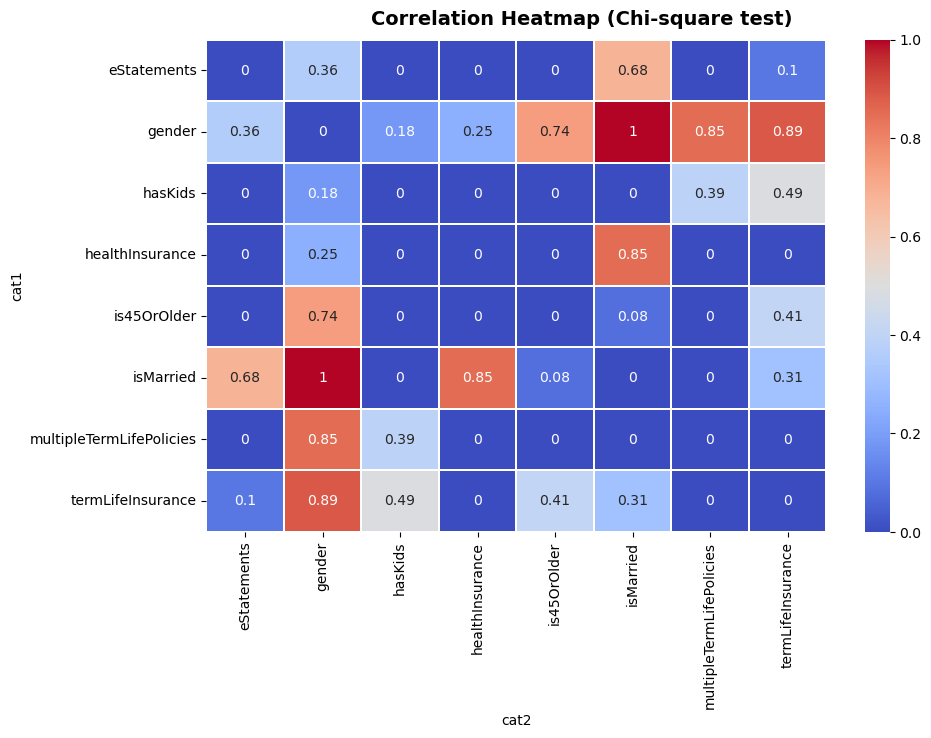

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(chisquare.pivot_table(index='cat1', columns='cat2', values='p-value'),2), 
                 ax=ax,           
                 cmap="coolwarm", 
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
t = fig.suptitle('Correlation Heatmap (Chi-square test)', fontsize=14, fontweight='bold')
plt.show()

<b> Observation </b> 

From the Chi-square test, it appears that there are many p-values lesser than the significance level of 0.05 which may lead to a conclusion that relationships exist between many of the categorical variables. As there are too many of such instances, I refrain from coming to any conclusion at this point and investigate this further by looking at information gain. 

#### Information Gain Heatmap

Information Gain measures the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable.



In [18]:
entropies = pd.DataFrame([(x, drv.entropy(df[x])) for x in cat_columns], columns=['cat1', 'H(cat1)'])
results = []
for cat1 in cat_columns:
    for cat2 in cat_columns:
        if cat1!=cat2:
            results.append((cat1, cat2, drv.entropy_conditional(df[cat1], df[cat2])))

conditional_entropy = pd.DataFrame(results, columns=['cat1', 'cat2', 'H(cat1|cat2)'])

information_gain = entropies.merge(conditional_entropy)
information_gain['information gain'] = information_gain['H(cat1)'] - information_gain['H(cat1|cat2)']
information_gain.head()

,cat1,H(cat1),cat2,H(cat1|cat2),information gain
0,gender,0.9999353456973106,is45OrOlder,1.001321060120423,-0.001386
1,gender,0.9999353456973106,isMarried,0.9999278462811947,0.000007
2,gender,0.9999353456973106,hasKids,1.0005442403068288,-0.000609
3,gender,0.9999353456973106,termLifeInsurance,0.9980775134905457,0.001858
4,gender,0.9999353456973106,multipleTermLifePolicies,0.9986956139790863,0.00124


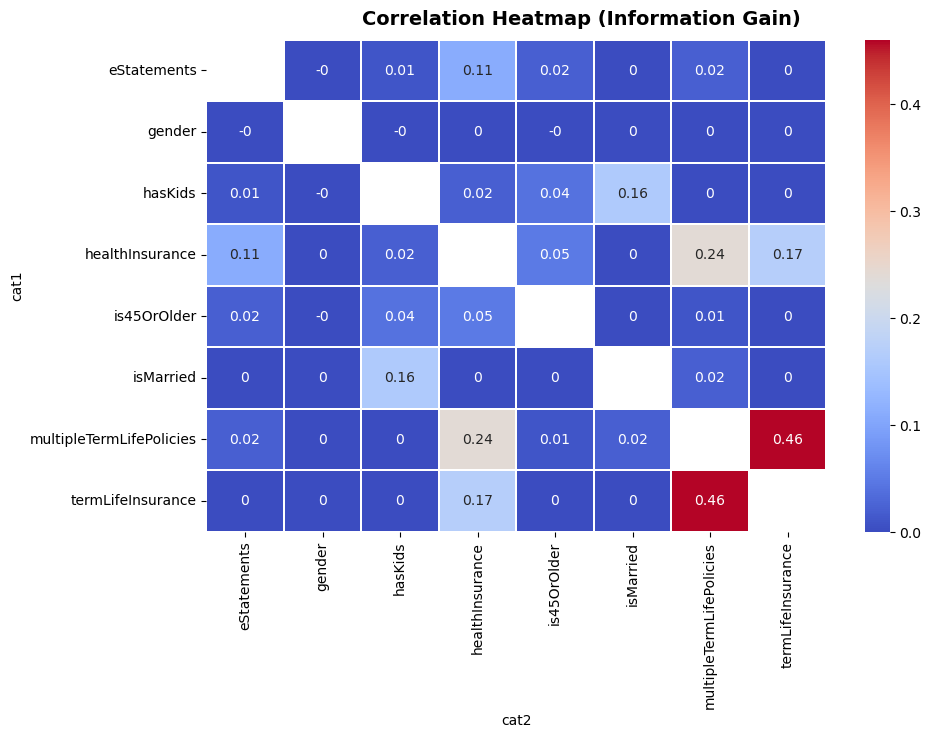

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2), 
                 ax=ax,           
                 cmap="coolwarm", 
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
t = fig.suptitle('Correlation Heatmap (Information Gain)', fontsize=14, fontweight='bold')
plt.show()

A larger information gain suggests a lower entropy group or groups of samples, and hence less surprise.

#### Combine termLifeInsurance and multipleTermLifePolicies

By investigating termLifeInsurance and multipleTermLifePolicies further, we can understand why these 2 features are very related. If termLifeInsurance is 'No', then insuree does not have any term life insurance hence multipleTermLifePolicies must be either 'no term life policy taken' or 'term life policy not taken'. If termLifeInsurance is 'Yes', then insuree can either have a single or multiple term life insurance policies. 

In [22]:
df['multipleTermLifePolicies'].unique()

array(['No', 'Yes', 'no term life policy taken',
       'term life policy not taken'], dtype=object)

In [23]:
df[df['termLifeInsurance'] == 'Yes']['multipleTermLifePolicies'].unique()

array(['No', 'Yes'], dtype=object)

In [24]:
df[df['termLifeInsurance'] == 'No']['multipleTermLifePolicies'].unique()

array(['no term life policy taken', 'term life policy not taken'],
      dtype=object)

Hence, we can create a new column termLifePolicy that has values 'single', 'multiple', or 'no' to capture the information represented by the columns termLifeInsurance and multipleTermLifePolicies in 1 column.

In [25]:
df['termLifePolicy'] = np.where(df['termLifeInsurance'] == 'No', 'no', 
                                np.where(df['multipleTermLifePolicies'] == 'Yes', 'multiple',
                                'single'
                                ))

df.drop(columns=['termLifeInsurance', 'multipleTermLifePolicies'], inplace=True)

In [26]:
df['termLifePolicy'].unique()

array(['single', 'multiple', 'no'], dtype=object)

In [28]:
df.head(5)

,gender,is45OrOlder,isMarried,hasKids,insuredMonths,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,target,termLifePolicy
0,F,0.0,Yes,Yes,23,No,NaN,12.0,Yes,19.65,451.55,0,single
1,F,1.0,No,No,42,Class A,3,1.0,Yes,84.65,3541.35,1,multiple
2,F,0.0,Yes,No,72,No,NaN,12.0,No,19.40,1496.45,0,single
3,F,0.0,Yes,Yes,13,No,NaN,12.0,No,19.55,265.30,0,single
4,F,0.0,No,No,37,Class A,"3,4",1.0,No,100.30,3541.40,0,multiple


### Investigate Outliers

In [29]:
df['target'] = df['target'].astype(str)

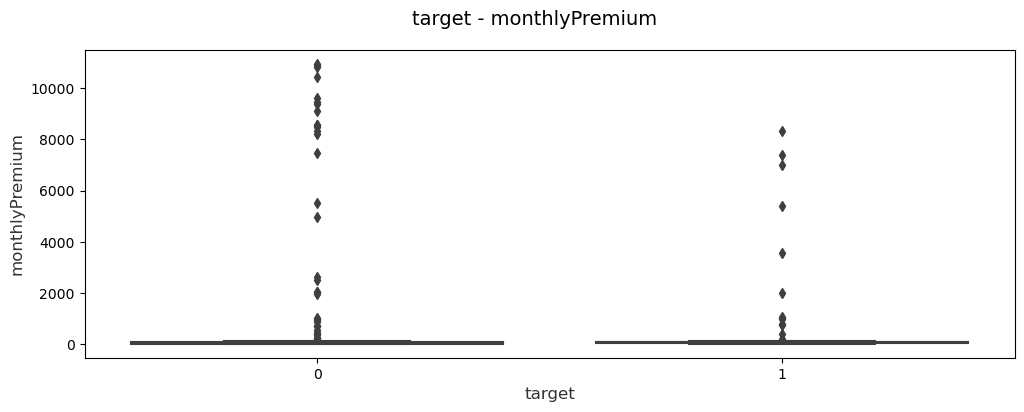

In [30]:
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('target - monthlyPremium', fontsize=14)

sns.boxplot(x="target", y="monthlyPremium", data=df,  ax=ax)
ax.set_xlabel("target",size = 12,alpha=0.8)
ax.set_ylabel("monthlyPremium",size = 12,alpha=0.8)
plt.show()

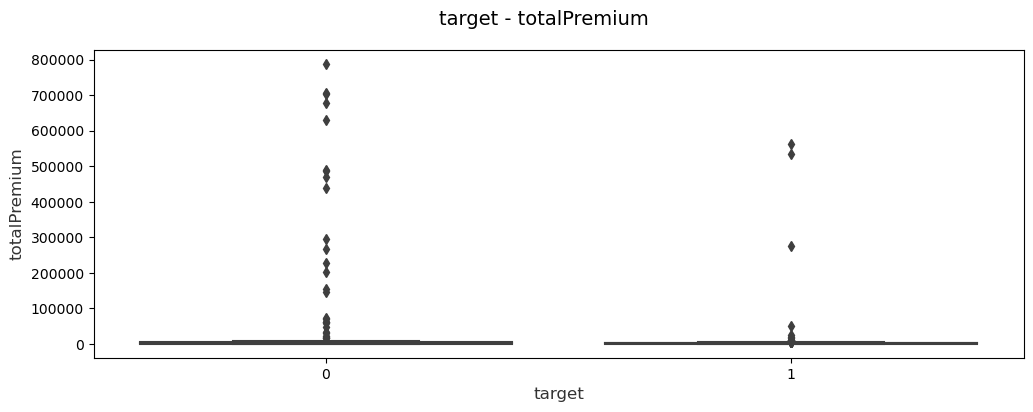

In [31]:
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('target - totalPremium', fontsize=14)

sns.boxplot(x="target", y="totalPremium", data=df,  ax=ax)
ax.set_xlabel("target",size = 12,alpha=0.8)
ax.set_ylabel("totalPremium",size = 12,alpha=0.8)
plt.show()

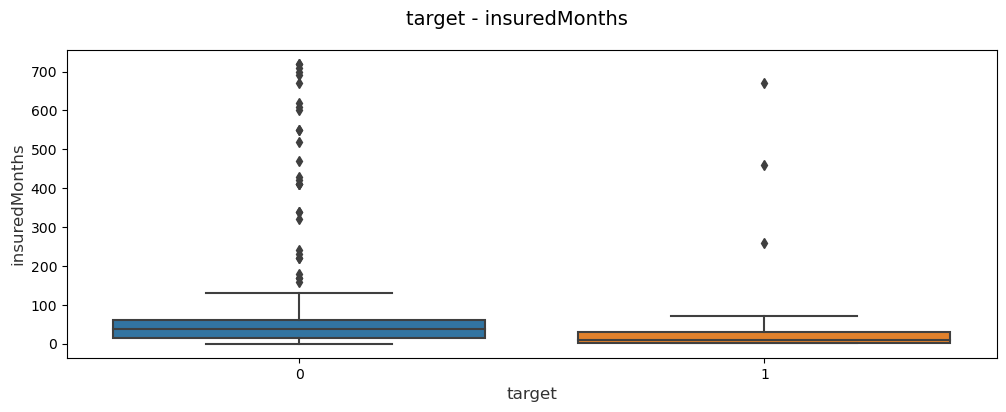

In [32]:
f, (ax) = plt.subplots(1, 1, figsize=(12, 4))
f.suptitle('target - insuredMonths', fontsize=14)

sns.boxplot(x="target", y="insuredMonths", data=df,  ax=ax)
ax.set_xlabel("target",size = 12,alpha=0.8)
ax.set_ylabel("insuredMonths",size = 12,alpha=0.8)
plt.show()

<b> Observations </b>

There appears to be a number of univariate outliers from looking at the features, monthlyPremium, totalPremium and insuredMonths. However, further investigation into these variables seem to show that they are true observations and not due to obvious measurement errors. Treatment methods of outliers such as winsorization is not used in this case as while these may be outliers looking at each feature, their values are related to the values of other features. For example, monthlyPremium that an insuree pays can be affected by the premiumFrequency and simply changing the values as in winsorization may introduce errors into the dataset. 

Hence, these univariate outliers are kept. When using techniques that are sensitive to outliers such as in scaling the data before doing logistic regression, techniques that are robust to outliers are chosen instead as seen in model.ipynb. 

In [33]:
df[df['totalPremium'] == df['totalPremium'].max()]

,gender,is45OrOlder,isMarried,hasKids,insuredMonths,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,target,termLifePolicy
2547,F,0.0,Yes,Yes,72,Class A,"1,2,3,4",12.0,No,10955.0,788725.0,0,multiple


In [34]:
df[df['monthlyPremium'] == df['monthlyPremium'].max()]

,gender,is45OrOlder,isMarried,hasKids,insuredMonths,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,target,termLifePolicy
2547,F,0.0,Yes,Yes,72,Class A,"1,2,3,4",12.0,No,10955.0,788725.0,0,multiple


### Explore riders

In [35]:
df['lst_healthRiders'] = df['healthRiders'].apply(lambda x : [int(i) for i in x.split(',')] if not pd.isna(x) else [])
df['num_healthRiders'] = df['lst_healthRiders'].map(lambda x: len(x))

In [36]:
average_riders = df['num_healthRiders'].sum() / len(df)
print(f'Average number of riders health insurance customers purchase is {average_riders:.2f}')

Average number of riders health insurance customers purchase is 1.39


In [37]:
# check that data is valid - all insurees with no healthInsurance should not have any healthRiders
df[df['healthInsurance'] == 'No']['num_healthRiders'].unique()

array([0], dtype=int64)

In [53]:
lst_riders = sum(df['lst_healthRiders'], [])
c_riders = Counter(lst_riders)
print(f'Top 3 most popular riders among all insurees {c_riders.most_common(3)}')

Top 3 most popular riders among all insurees [(4, 2101), (3, 2099), (2, 1888)]


In [52]:
lst_riders_older = sum(df[df['is45OrOlder'] == '1.0']['lst_healthRiders'], [])
c_riders_older = Counter(lst_riders_older)
print(f'Top 3 most popular riders among older people {c_riders_older.most_common(3)}')

Top 3 most popular riders among older people [(4, 437), (3, 429), (2, 363)]


In [54]:
lst_riders_younger = sum(df[df['is45OrOlder'] != '1.0']['lst_healthRiders'], [])
c_riders_younger = Counter(lst_riders_younger)
print(f'Top 3 most popular riders among insurees who are not 45 or older {c_riders_younger.most_common(3)}')

Top 3 most popular riders among insurees who are not 45 or older [(3, 1670), (4, 1664), (2, 1525)]


<b> Observations </b>

* The average number of riders health insurance customers purchase is 1.39. 
* Top 3 most popular riders among all insurees are health rider 4, followed by health rider 3 and health rider 2.
* Most popular rider for older people is health rider 4.
* The most popular rider for older people differs from the most popular rider for non-older people as the most popular rider for insurees who are not 45 or older is health rider 3 instead of health rider 4. However, the difference is not that large. 